# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 2 weeks for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand. 

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [2]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if len(y) == 0:
      return 0
    return np.sum((y - np.mean(y)) ** 2) / len(y)

In [3]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [4]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """   
    if len(y) == 0:
      return 0
    
    R_left = y[X[:, j] <= t]
    R_right = y[X[:, j] > t]
    Q = len(R_left) / len(y) * H(R_left) + len(R_right) / len(y) * H(R_right)
    return Q

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [5]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    left* : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node 
        (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

In [50]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """ 
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
            
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y) 

        X_left, y_left, X_right, y_right = None, None, None, None
        
        for j in range(X.shape[1]):
          for i in range(len(X[:, j])):
            t = X[i, j]
            current_cost = Q(X, y, j, t)
                
            if current_cost < best_cost:
              best_split_column = j
              best_threshold = t
              best_cost = current_cost
              X_left = X[X[:, best_split_column] <= best_threshold]
              y_left = y[X[:, best_split_column] <= best_threshold]
              X_right = X[X[:, best_split_column] > best_threshold]
              y_right = y[X[:, best_split_column] > best_threshold]

        return best_split_column, best_threshold, X_left, y_left, X_right, y_right
    
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth`, 
        `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        return False
        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        
        if self.is_terminal(node, y):
            node.is_terminal = True
            return
        
        node.column, node.threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)

        if node.column is None or len(X_left) < self.min_samples_split or len(X_right) < self.min_samples_split:
            node.is_terminal = True
            return

        node.left = Node()
        node.right = Node()

        node.left.depth = node.depth + 1
        node.right.depth = node.depth + 1

        node.left.prediction = np.mean(y_left)
        node.right.prediction = np.mean(y_right)
        self.grow_tree(node.right, X_right, y_right)
        self.grow_tree(node.left, X_left, y_left)
        
    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        # По совету из семинарского чата
        self.n_features_in_ = X.shape[1]
        
        # Initialize the tree (root node)
        self.tree_ = Node()
        # Кажется, что у корневой вершины глубина все же 0...                             
        self.tree_.depth = 0                            
        self.tree_.prediction = np.mean(y)
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self        
    
    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get 
            predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        if node.is_terminal:
          return node.prediction
        if x[node.column] > node.threshold:
          y_pred = self.get_prediction(node.right, x)
        else:
          y_pred = self.get_prediction(node.left, x)
        
        return y_pred
    
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

    # estimators should have a 'requires_y' tag set to the appropriate value
    # Чтобы убрать warning
    def _more_tags(self):
      return {'requires_y': False}

In [51]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of depth 1 and make the following plot:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model 

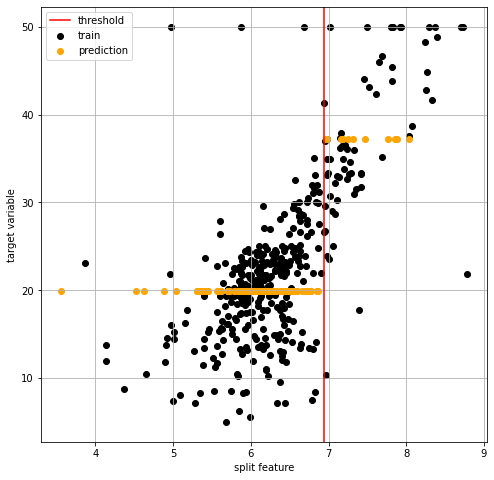

In [7]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

# Возник warning, поэтому переписала в соответствии с рекомендацией
# data = load_boston()
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

X, y = data, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = MyDecisionTreeRegressor(max_depth = 1, min_samples_split = 1)
model.fit(X_train, y_train)
pred = model.predict(X_test)

plt.figure(figsize=(8,8))

plt.scatter(X_train[:, model.tree_.column], y_train, color = 'black', label = 'train')      
plt.scatter(X_test[:, model.tree_.column], pred, color = 'orange', label = 'prediction')
plt.axvline(model.tree_.threshold, color = 'red', label = 'threshold')

plt.xlabel('split feature')
plt.ylabel('target variable')
plt.legend(loc = 'best')
plt.grid()
plt.show()

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `MAE` on test dataset and hyperparameters of the best estimator. 

min_samples_leaf нигде не меняется в программе, кажется что его не очень информативно подбирать по сетке (лучшим останется 1), поэтому добавила в поиск min_samples_split

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

parameters = {'max_depth':[1, 3, 5, 7, 10], 
              'min_samples_split' : [2, 5, 10, 20],
              'min_samples_leaf':[1, 5, 10, 50]}

cv = GridSearchCV(MyDecisionTreeRegressor(),          
                  parameters,         
                  scoring = 'neg_mean_absolute_error',
                  cv = 5) 

cv.fit(X_train, y_train)
print(f'Hyperparameters of the best estimator: {cv.best_params_}')
max_depth, min_samples_split, min_samples_leaf = cv.best_params_["max_depth"], \
                                                 cv.best_params_["min_samples_split"], \
                                                 cv.best_params_["min_samples_leaf"]

Hyperparameters of the best estimator: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [37]:
best_model = MyDecisionTreeRegressor(max_depth = int(max_depth), min_samples_split = int(min_samples_split), min_samples_leaf = int(min_samples_leaf))
best_model.fit(X_train, y_train)
best_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, best_pred)
print(f'MAE of the best estimator: {mae}')

print(f'Accuracy on test: {best_model.score(X_test, y_test)}')

MAE of the best estimator: 2.3674274340013413
Accuracy on test: 0.8378513713758426


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized. 

In [8]:
np.random.seed(42)
def bootstrap(x, y):
    indices = np.random.choice(np.arange(x.shape[0]), size = x.shape[0], replace = True)
    return x[indices], y[indices], indices

def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias and variance of the `estimator`. 
    Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """
    pred = np.full([x.shape[0], n_iter], np.nan)
    max_length = 0
    np.random.seed(42)
    for iter in range(n_iter):
        x_i, y_i, chosen = bootstrap(x, y)
        out_of_bag = np.setxor1d(np.arange(x.shape[0]), np.unique(chosen))

        z_i = np.take(x, out_of_bag, axis=0)
        
        estimator.fit(x_i, y_i)
        pred_y =  estimator.predict(z_i)
        pred[out_of_bag, iter] = pred_y

    bias2 = np.nanmean(np.square(y - np.nanmean(pred, axis=1)))
    variance = np.nanmean(np.nanvar(pred, axis=1))
    
    return bias2, variance

In [50]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

# numpy.ndarray has no attribute value :(
get_bias_variance(estimator, X_train, y_train, 10)

(23.694561300313893, 7.496614983293238)

Найдем для лучшей по сетке модели

In [47]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=5, min_samples_split=2)

# numpy.ndarray has no attribute value :(
get_bias_variance(estimator, X_train, y_train, 10)

(18.61989234885744, 8.353618040359025)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases. 

Comment on what you observe, how does your result correspond to theory?

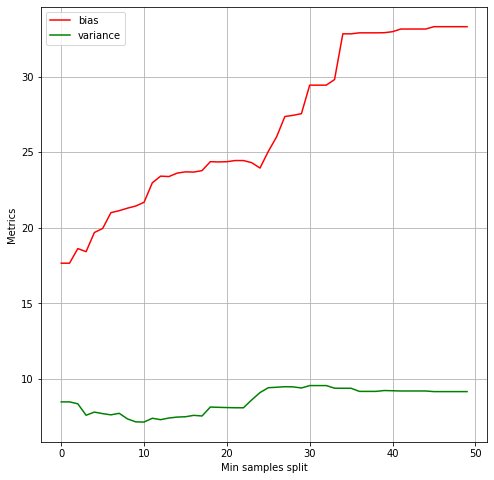

In [59]:
mss_parameters = np.arange(50)
biases = []
variances = []
for min_samples_split in mss_parameters:
    estimator = MyDecisionTreeRegressor(max_depth = 5, min_samples_split = min_samples_split)

    bias2, variance = get_bias_variance(estimator, X_train, y_train, 10)
    biases.append(bias2)
    variances.append(variance)

plt.figure(figsize = (8,8))

plt.plot(mss_parameters, biases, color = 'red', label = 'bias')      
plt.plot(mss_parameters, variances, color = 'green', label = 'variance')
plt.xlabel('Min samples split')
plt.ylabel('Metrics')
plt.legend(loc = 'best')
plt.grid()
plt.show()

Этот код работал 7 минут)) Но зато у нас есть четкая картина (кажется)

**THEORY BLOCK**

*Bias* отображает ошибку, связанную с плохо выработанными зависимостями

Уменьшается с ростом сложности и при больших значениях говорит о том, что модель недостаточно обучена

*Variance* отображает чувствительность модели к колебаниям в значениях входных данных

Увеличивается с ростом сложности и свидетельствует о переобучении

**RESULT**

В целом, с теорией все сходится)

min_samples_split определяет минимальное количество выборок, которое внутренний узел должен содержать для разделения на следующие узлы

Увеличивая этот параметр мы контролируем переобучение (variance падает), но при слишком больших значениях модель недообучается (bias стремительно растет вверх)

Можем заметить, что оптимальное число min_samples_split равно 2, после этого модель плавно начинает недообучаться

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [16]:
from sklearn.ensemble import BaggingRegressor

self_written = BaggingRegressor(MyDecisionTreeRegressor(max_depth = 5, min_samples_split = 2), random_state = 42)
self_written_bias, self_written_variance = get_bias_variance(self_written, X_train, y_train, 10)

print(f'OUR model: {self_written_bias:.2f}, {self_written_variance:.2f}')

OUR model: 14.86, 2.20


**THEORY BLOCK**

*(first question)*

Используется для уменьшения ошибки путем усреднения результатов

Бэггинг позволяет снизить variance (предотвращая переобучение), точность при этом должна увеличиваться (bias тоже снижается), но не так существенно (улучшение достигается за счет уменьшения чувствительности к данным)

Бэггинг эффективен на малых выборках, когда исключение даже малой части обучающих объектов приводит к построению *существенно различных базовых классификаторов*, что позволяет компенсировать ошибки

**RESULT**

*(second question)*

Отдельное дерево (лучшее по сетке): bias = 18.6; variance = 8.4

Ансамбль: bias = 14.86; variance: 2.20

Variance сльно меняется, уменьшилась в 3,8 раза; Bias - менее, но тоже заметно меньше, уменьшился примерно в 1,25 раза

*(third question)*

С теорией результат, в целом, сходится))

Результат ансамбля лучше, чем у отдельного дерева (причем это отдельное дерево - лучшее по гридсерчу)

Усреднение ответов действительно приводит к уменьшению чувствительности к данным и улучшению метрик

# Part 2. More Ensembles

In this part we will be working with [Thyroid Disease Data Set](https://archive.ics.uci.edu/ml/datasets/thyroid+disease) to solve a classification task. 

In [9]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('thyroid_disease.csv')

le = LabelEncoder()
y = le.fit_transform(df['Class'])
X = df.drop('Class', axis=1)
X.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source
0,41.0,F,f,f,f,f,f,f,f,f,...,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC
1,23.0,F,f,f,f,f,f,f,f,f,...,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other
2,46.0,M,f,f,f,f,f,f,f,f,...,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other
3,70.0,F,t,f,f,f,f,f,f,f,...,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other
4,70.0,F,f,f,f,f,f,f,f,f,...,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset. 

In [21]:
X.shape

(3772, 29)

In [20]:
X.isna().sum()

age                             1
sex                           150
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
I131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH_measured                    0
TSH                           369
T3_measured                     0
T3                            769
TT4_measured                    0
TT4                           231
T4U_measured                    0
T4U                           387
FTI_measured                    0
FTI                           385
TBG_measured                    0
TBG                          3772
referral_source                 0
dtype: int64

TBG вообще не имеет значений :(

Придется удалить)

In [10]:
X = df.drop(['Class','TBG'], axis=1)
X

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,referral_source
0,41.0,F,f,f,f,f,f,f,f,f,...,t,2.5,t,125.0,t,1.14,t,109.0,f,SVHC
1,23.0,F,f,f,f,f,f,f,f,f,...,t,2.0,t,102.0,f,NaN,f,NaN,f,other
2,46.0,M,f,f,f,f,f,f,f,f,...,f,NaN,t,109.0,t,0.91,t,120.0,f,other
3,70.0,F,t,f,f,f,f,f,f,f,...,t,1.9,t,175.0,f,NaN,f,NaN,f,other
4,70.0,F,f,f,f,f,f,f,f,f,...,t,1.2,t,61.0,t,0.87,t,70.0,f,SVI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30.0,F,f,f,f,f,f,f,f,f,...,f,NaN,f,NaN,f,NaN,f,NaN,f,other
3768,68.0,F,f,f,f,f,f,f,f,f,...,t,2.1,t,124.0,t,1.08,t,114.0,f,SVI
3769,74.0,F,f,f,f,f,f,f,f,f,...,t,1.8,t,112.0,t,1.07,t,105.0,f,other
3770,72.0,M,f,f,f,f,f,f,f,f,...,t,2.0,t,82.0,t,0.94,t,87.0,f,SVI


In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# define column_transformer 
cat_transform = make_pipeline(SimpleImputer(missing_values = np.nan, strategy = 'constant'), OneHotEncoder(drop = 'if_binary'))

numeric_transform = make_pipeline(SimpleImputer(missing_values = np.nan, strategy = 'mean'), StandardScaler())

column_transformer = ColumnTransformer(
    transformers = [
        ('categorical', cat_transform, X.select_dtypes('object').columns),
        ('numeric', numeric_transform, X.select_dtypes('number').columns)], 
    remainder='passthrough')

# Transform the data
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

In [69]:
X_train

array([[ 1.        ,  0.        ,  0.        , ...,  0.75989018,
         1.19103783,  0.01173106],
       [ 1.        ,  0.        ,  0.        , ..., -1.20881984,
         1.24600748, -1.78056017],
       [ 1.        ,  0.        ,  0.        , ...,  2.8141963 ,
         3.16994504,  0.67204889],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  1.70144715,
        -0.07326399,  1.89835341],
       [ 1.        ,  0.        ,  0.        , ...,  0.53163395,
        -0.56799079,  1.01792965],
       [ 0.        ,  1.        ,  0.        , ...,  1.18787062,
        -0.62296044,  1.89835341]])

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [67]:
len(y_test[y_test==0])

893

In [61]:
print(f'Is classes balanced: { len(y[y==0]) / len(y) }')

Is classes balanced: 0.9387592788971368


Классы не сбалансированы (отрицательные результаты составляют 93% всего датасета)

Будем использовать F1-меру)

GradientBoostingClassifier(n_estimators=70, random_state=42)
f1_score on test: 0.9842
f1_score on train : 0.9831
Overfitting: False


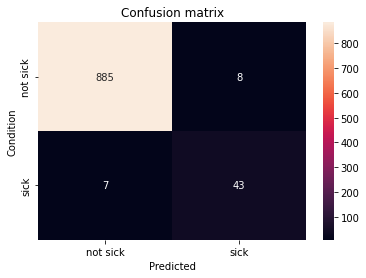


RandomForestClassifier(class_weight='balanced', n_estimators=70,
                       random_state=42)
f1_score on test: 0.9779
f1_score on train : 0.9784
Overfitting: True


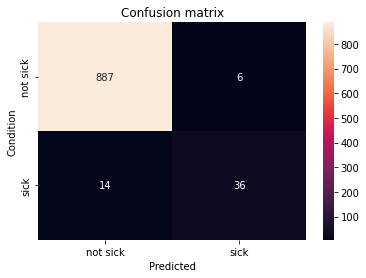


DecisionTreeClassifier(class_weight='balanced', random_state=42)
f1_score on test: 0.9805
f1_score on train : 0.9833
Overfitting: True


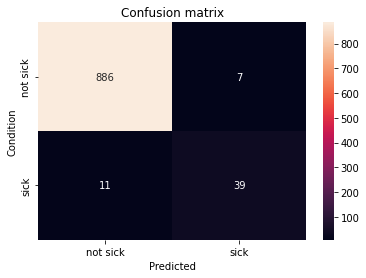


SVC(class_weight='balanced', max_iter=500, random_state=42)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


f1_score on test: 0.9528
f1_score on train : 0.9595
Overfitting: True


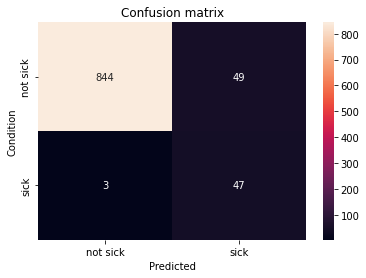


LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)
f1_score on test: 0.9155
f1_score on train : 0.9171
Overfitting: True


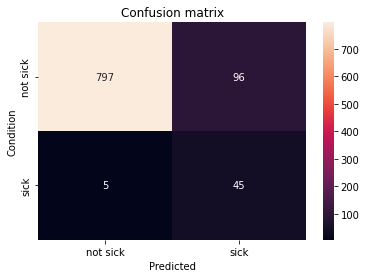

In [48]:
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_validate
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

def train(model):
  print(model)
  cv = StratifiedKFold(3)
  
  cross_val = cross_validate(model, X_train, y_train, cv=cv, scoring = 'f1_weighted', return_estimator=True)
  
  pred = cross_val['estimator'][0].predict(X_test)
  train = np.mean(cross_val['test_score'])
  f1 = f1_score(y_test, pred, average = 'weighted')

  print(f'f1_score on test: {f1:.4f}')
  print(f'f1_score on train : {train:.4f}')
  print(f'Overfitting: {train > f1}')
  labels = ['not sick', 'sick']
  sns.heatmap(confusion_matrix(y_test, pred), annot = True, fmt = "d", xticklabels = labels, yticklabels = labels)
  plt.title('Confusion matrix')
  plt.ylabel('Condition')
  plt.xlabel('Predicted')
  plt.show()
  print('========================\n')

models = [GradientBoostingClassifier(n_estimators=70, random_state=42),
          RandomForestClassifier(n_estimators=70, random_state=42, class_weight = 'balanced'),
          DecisionTreeClassifier(random_state=42, class_weight = 'balanced'),
          SVC(max_iter=500, random_state=42, class_weight = 'balanced'),
          LogisticRegression(max_iter=500, random_state=42, class_weight = 'balanced')]

for model in models:
    train(model)

Best perfomance: бустинг (f1 = 0.98 + не переобучилась)

Хорошо еще себя зарекомендовал random forest и dt, у них такой же f1, и очень похожие на бустинг значения в confusion matrix
Все модели показали примерно одинаковый результат, хуже всего зарекомендовала себя регрессия

Не переобучилась только одна модель: градиентный бустинг

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to implement one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 

To get method that you have to implement, run cell below and input your name in Russian (for example, if you input Андрей, you will see that user with this name should implement xgboost)

In [ ]:
def assign_method():
    name = input()
    methods = ['xgboost', 'lightgbm', 'catboost']
    idx = sum([ord(x) for x in list(name)]) % 3
    print('Реализуйте', methods[idx])
    
assign_method()

Анастасия
Реализуйте xgboost


In [22]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xgboost_model = xgb.XGBClassifier()
parameters = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.5, 1], 
    'max_depth': [1, 5, 10, 20], 
    'n_estimators': [50, 100, 500, 1000]
}

grid_search = GridSearchCV(xgboost_model, param_grid = parameters, cv = StratifiedKFold(n_splits = 5))
grid_search.fit(X_train, y_train)

grid_search.best_estimator_

XGBClassifier(learning_rate=0.01, max_depth=5, n_estimators=500)

9 минут 😰

Лучшие параметры: lr = 0.01, depth = 5, n = 500))

XGBClassifier(learning_rate=0.01, max_depth=5, n_estimators=500)
f1_score : 0.98
Overfitting: True


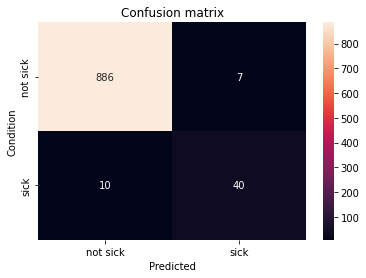

In [23]:
train(xgb.XGBClassifier(max_depth=5, n_estimators=500, learning_rate=0.01))

Очень похоже на дерево (с точностью до 1, он его посчитал тру sick)

Кажется, что прям улучшить результат не получилось (0.98), но мы нечего и не ухудшили (УСПЕХ!)

Модель также переобучается, но видимо не сильно, раз f1_score все равно очень высокий)

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [45]:
from sklearn.metrics import accuracy_score

def new_train(model):
  model = model.fit(X_train, y_train)

  pred_train = model.predict(X_train)
  pred_test = model.predict(X_test)

  f1_train = f1_score(y_train, pred_train, average = 'weighted')
  f1_test = f1_score(y_test, pred_test, average = 'weighted')
  accuracy_test = accuracy_score(y_test, pred_test)

  print(f'f1_score on train: {f1_train:.4f}')
  print(f'f1_score on test: {f1_test:.4f}')
  print(f'Accuracy : {accuracy_test:.4f}')
  print(f'Overfitting: {f1_train > f1_test}')
  labels = ['not sick', 'sick']
  sns.heatmap(confusion_matrix(y_test, pred_test), annot = True, fmt = "d", xticklabels = labels, yticklabels = labels)
  plt.title('Confusion matrix')
  plt.ylabel('Condition')
  plt.xlabel('Predicted')
  plt.show()
  print('========================\n')

f1_score on train: 0.9986
f1_score on test: 0.9837
Accuracy : 0.9841
Overfitting: True


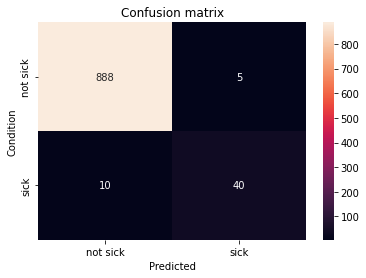


f1_score on train: 0.9979
f1_score on test: 0.9894
Accuracy : 0.9894
Overfitting: True


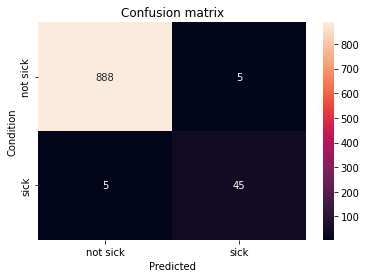


f1_score on train: 1.0000
f1_score on test: 0.9863
Accuracy : 0.9862
Overfitting: True


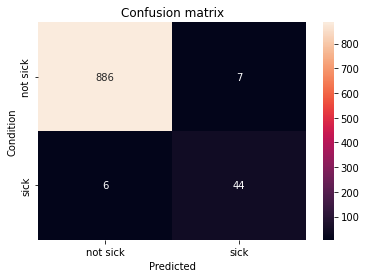


f1_score on train: 0.9975
f1_score on test: 0.9783
Accuracy : 0.9767
Overfitting: True


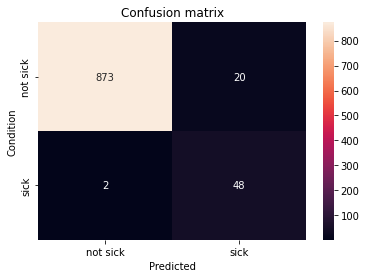


f1_score on train: 0.9979
f1_score on test: 0.9825
Accuracy : 0.9820
Overfitting: True


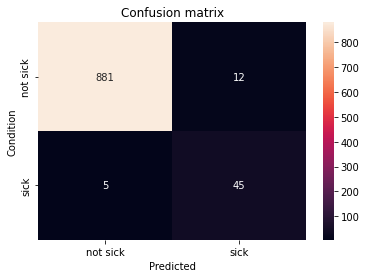

In [46]:
from sklearn.ensemble import BaggingClassifier, StackingClassifier, VotingClassifier

estimators = [('lr', LogisticRegression(class_weight = 'balanced', max_iter = 1500)), 
                ('rf', RandomForestClassifier(class_weight = 'balanced', n_estimators = 200)), 
                ('gb', GradientBoostingClassifier(n_estimators = 200))]

baggingDT = BaggingClassifier(base_estimator = DecisionTreeClassifier(class_weight = 'balanced', random_state=42))

baggingGB = BaggingClassifier(base_estimator = GradientBoostingClassifier(n_estimators=250, random_state=42))

voting = VotingClassifier(estimators=estimators, voting='hard')

stackingLR = StackingClassifier(estimators=estimators, final_estimator = LogisticRegression(max_iter=1500, random_state=42, class_weight = 'balanced'), cv = StratifiedKFold(n_splits = 3))

stackingGB = StackingClassifier(estimators=estimators, final_estimator = GradientBoostingClassifier(n_estimators=250, random_state=42), cv = StratifiedKFold(n_splits = 3))

models = [baggingDT, baggingGB, voting, stackingLR, stackingGB]

for model in models:
    new_train(model)

Бэггинг с градиентным бустингом и voting смогли выбить почти 0.99 на тестовой выборке (ШОК!)

*(first question)*

Видимо, именно их и можно назвать лучшими perfomance)

*(second question)*

Больше всего переобучается voting

Метрики для градиентного бустинга: f1_test =0.9842; f1_train = 0.9831 (нужно учесть, что разные n_estimators)

Метрики для бэггинга с ним: f1_test = 0.9894, f1_train = 0.9979

В первом случае модель не переобучилась, во втором наоборот => бэггинг не уменьшает переобучение)

*(third question)*

Voting: смотрим решения эстиматоров, выбираем то, за которое больше всего голосов

Stacking: смотрим решения эстиматоров, выбираем то, за которое больше всего голосов, *сверяемся с финальным эстиматором*

То есть отличие в том, что в staking'е решение мы принимаем не просто по среднему, а по среднему с учетом решения финального)

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train. 

**AND THE WINNER IS...**

Кажется, что бэггинг с гб был самым лучшим)

***CONGRATULATIONS***

In [49]:
from sklearn.metrics import precision_score, recall_score

print('Bagging with gradient boosting (with large amount of trees, >100) as base estimators')
model = BaggingClassifier(base_estimator = GradientBoostingClassifier(n_estimators=250, random_state=42))
model = model.fit(X_train, y_train)

pred = model.predict(X_test)

f1_test = f1_score(y_test, pred, average = 'weighted')
recall_test = f1_score(y_test, pred, average = 'weighted')
precision_test = f1_score(y_test, pred, average = 'weighted')
accuracy_test = accuracy_score(y_test, pred)

print(f'f1: {f1_test:.4f}')
print(f'Recall: {recall_test:.4f}')
print(f'Precision: {precision_test:.4f}')
print(f'Accuracy : {accuracy_test:.4f}')

Bagging with gradient boosting (with large amount of trees, >100) as base estimators
f1: 0.9884
Recall: 0.9884
Precision: 0.9884
Accuracy : 0.9883
